In [6]:
%matplotlib inline
from __future__ import division
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

In [7]:
class Bandit(object):

    def generate_reward(self, i):
        raise NotImplementedError


class BernoulliBandit(Bandit):

    def __init__(self, n, probas=None):
        assert probas is None or len(probas) == n
        self.n = n
        if not probas:
            np.random.seed(int(time.time()))
            self.probas = [np.random.random() for _ in range(self.n)]
        else:
            self.probas = probas

        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        # The player selected the i-th machine.
        if np.random.random() < self.probas[i]:
            return 1
        else:
            return 0

In [8]:
class MABAlgo(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve.
        """
        assert isinstance(bandit, BernoulliBandit)
        np.random.seed(int(time.time()))

        self.bandit = bandit

        self.counts = [0] * self.bandit.n
        self.actions = []  # A list of machine ids, 0 to bandit: n-1.
        self.regret = 0.  # Cumulative regret.
        self.regrets = [0.]  # History of cumulative regret.

    def update_regret(self, i):
        # i (int): index of the selected machine.
        self.regret += self.bandit.best_proba - self.bandit.probas[i]
        self.regrets.append(self.regret)

    @property
    def estimated_probas(self):
        raise NotImplementedError

    def run_one_step(self):
        """Return the machine index to take action on."""
        raise NotImplementedError

    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()

            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)


class EpsilonGreedy(MABAlgo):
    def __init__(self, bandit, eps, init_proba=1.0):
        """
        eps (float): the probability to explore at each time step.
        init_proba (float): default to be 1.0; optimistic initialization
        """
        super(EpsilonGreedy, self).__init__(bandit)

        assert 0. <= eps <= 1.0
        self.eps = eps

        self.estimates = [init_proba] * self.bandit.n  # Optimistic initialization

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        if np.random.random() < self.eps:
            # Let's do random exploration!
            i = np.random.randint(0, self.bandit.n)
        else:
            # Pick the best one.
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        r = self.bandit.generate_reward(i)
        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i


class UCB1(MABAlgo):
    def __init__(self, bandit, init_proba=1.0):
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [init_proba] * self.bandit.n

    @property
    def estimated_probas(self):
        return self.estimates

    def run_one_step(self):
        self.t += 1

        # Pick the best one with consideration of upper confidence bounds.
        i = max(range(self.bandit.n), key=lambda x: self.estimates[x] 
                + np.sqrt(2 * np.log(self.t) / (1 + self.counts[x])))
        r = self.bandit.generate_reward(i)

        self.estimates[i] += 1. / (self.counts[i] + 1) * (r - self.estimates[i])

        return i

class ThompsonSampling(MABAlgo):
    def __init__(self, bandit, init_a=1, init_b=1):
        """
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._as = [init_a] * self.bandit.n
        self._bs = [init_b] * self.bandit.n

    @property
    def estimated_probas(self):
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._as[x], self._bs[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        r = self.bandit.generate_reward(i)

        self._as[i] += r
        self._bs[i] += (1 - r)

        return i

In [9]:
def plot_results(algos, algos_names, figname):
    """
    Plot the results by multi-armed bandit solvers.
    Args:
        algos (list<Algo>): All of them should have been fitted.
        algos_names (list<str)
        figname (str)
    """
    assert len(algos) == len(algos_names)
    assert all(map(lambda s: isinstance(s, MABAlgo), algos))
    assert all(map(lambda s: len(s.regrets) > 0, algos))

    b = algos[0].bandit

    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.3, wspace=0.3)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Sub.fig. 1: Regrets in time.
    for i, algo in enumerate(algos):
        ax1.plot(range(len(algo.regrets)), algo.regrets, label=algos_names[i])

    ax1.set_xlabel('Time step')
    ax1.set_ylabel('Cumulative regret')
    ax1.legend(loc=9, bbox_to_anchor=(1.2, -0.25), ncol=5)
    ax1.grid('k', ls='--', alpha=0.3)

    # Sub.fig. 2: Probabilities estimated by algos.
    sorted_indices = sorted(range(b.n), key=lambda x: b.probas[x])
    ax2.plot(range(b.n), [b.probas[x] for x in sorted_indices], 'k--', markersize=12)
    for algo in algos:
        ax2.plot(range(b.n), [algo.estimated_probas[x] for x in sorted_indices], 'x', markeredgewidth=2)
    ax2.set_xlabel('Actions sorted by bandit reward probabilities')
    ax2.set_ylabel('Estimated probabilities')
    ax2.grid('k', ls='--', alpha=0.3)
    
    plt.show()
    plt.savefig(figname)


def experiment(K, N):
    """
    Run a small experiment on solving a Bernoulli bandit with K slot machines,
    each with a randomly initialized reward probability.
    Args:
        K (int): number of slot machines.
        N (int): number of time steps to try.
    """

    b = BernoulliBandit(K)
    print ("Randomly generated Bernoulli bandit has reward probabilities:{}\n".format(b.probas))
    print ("The best machine has index: {} and proba: {}"
           .format(max(range(K), key=lambda i: b.probas[i]), max(b.probas)))

    test_algos = [
        # EpsilonGreedy(b, 0),
        # EpsilonGreedy(b, 1),
        EpsilonGreedy(b, 0.01),
        UCB1(b),
        ThompsonSampling(b, 1, 1)
    ]
    names = [
        r'$\epsilon$' + '-Greedy',
        'UCB1',
        'Thompson Sampling'
    ]

    for algo in test_algos:
        algo.run(N)

    plot_results(test_algos, names, "results_K{}_N{}.png".format(K, N))

Randomly generated Bernoulli bandit has reward probabilities:[0.9954280986069652, 0.18417307765721225, 0.25381534195209676, 0.11630907033348403, 0.5184884897115666, 0.12033281955108732, 0.1618118022633046, 0.8908808284313386, 0.9713089828613146, 0.6356503533820057]

The best machine has index: 0 and proba: 0.9954280986069652


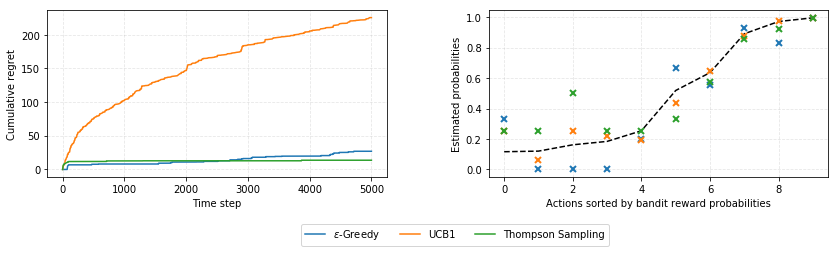

<Figure size 432x288 with 0 Axes>

In [10]:
experiment(10, 5000);